In [1]:
import pathlib
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import pandas as pd
import tarfile 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('./drive/MyDrive/fer2013.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [5]:
import numpy as np
def augment_pixels(px, IMG_SIZE = 48):
    image = np.array(px.split(' ')).reshape(IMG_SIZE, IMG_SIZE).astype('float32')
    image = tf.image.random_flip_left_right(image.reshape(IMG_SIZE,IMG_SIZE,1))
    # Pad image size
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 12, IMG_SIZE + 12) 
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 1])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0, 255)
    augmented = image.numpy().reshape(IMG_SIZE,IMG_SIZE)
    str_augmented = ' '.join(augmented.reshape(IMG_SIZE*IMG_SIZE).astype('int').astype(str))
    return str_augmented

valcounts = df.emotion.value_counts()
valcounts_diff = valcounts[valcounts.idxmax()] - valcounts
for emotion_idx, aug_count in valcounts_diff.iteritems():
    sampled = df.query("emotion==@emotion_idx").sample(aug_count, replace=True)
    sampled['pixels'] = sampled.pixels.apply(augment_pixels)
    df = pd.concat([df, sampled])
    print(emotion_idx, aug_count)

3 0
6 2791
4 2912
2 3868
0 4036
5 4987
1 8442


In [6]:
INTERESTED_LABELS = [0, 1, 2, 3, 4, 5, 6]

In [7]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
21744,1,94 75 79 91 100 103 83 98 101 122 125 100 140 ...,Training
16000,1,0 24 14 0 0 3 8 15 17 11 29 60 102 128 138 150...,Training
8823,1,146 144 141 142 138 137 142 149 158 159 160 15...,Training
13857,1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 87 196 198 211...,Training


In [8]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)


In [9]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((50338, 48, 48, 1), (12585, 48, 48, 1), (50338, 7), (12585, 7))

In [11]:
model = models.Sequential([
            
    layers.Conv2D(filters=48,kernel_size=(5,5),  input_shape = (48, 48, 1),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=48,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    #layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    #layers.MaxPooling2D(pool_size=(2,2)),
    #layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(7, activation='softmax')
])

In [12]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['acc'])

In [13]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [15]:
history = model.fit(X_train,y_train,validation_split=0.16, epochs=20,callbacks=[es], verbose=1)

Epoch 1/20
1322/1322 [==============================] - 156s 117ms/step - loss: 1.6579 - acc: 0.3525 - val_loss: 1.4792 - val_acc: 0.4340
Epoch 2/20
1322/1322 [==============================] - 155s 118ms/step - loss: 1.4538 - acc: 0.4451 - val_loss: 1.3972 - val_acc: 0.4668
Epoch 3/20
1322/1322 [==============================] - 155s 117ms/step - loss: 1.3559 - acc: 0.4881 - val_loss: 1.3346 - val_acc: 0.4885
Epoch 4/20
1322/1322 [==============================] - 154s 116ms/step - loss: 1.2871 - acc: 0.5108 - val_loss: 1.2965 - val_acc: 0.5073
Epoch 5/20
1322/1322 [==============================] - 154s 116ms/step - loss: 1.2290 - acc: 0.5347 - val_loss: 1.2729 - val_acc: 0.5177
Epoch 6/20
1322/1322 [==============================] - 156s 118ms/step - loss: 1.1737 - acc: 0.5549 - val_loss: 1.2820 - val_acc: 0.5104
Epoch 7/20
1322/1322 [==============================] - 154s 116ms/step - loss: 1.1256 - acc: 0.5747 - val_loss: 1.2581 - val_acc: 0.5227
Epoch 8/20
1322/1322 [============

In [16]:
model_json = model.to_json()
with open("Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("Classifier.h5")
print("Saved model to disk")
model.save_weights("CNN.h5")

Saved model to disk


In [17]:
loss, accuracy = model.evaluate(X_train,y_train)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

1574/1574 [==============================] - 45s 29ms/step - loss: 0.6185 - acc: 0.8077
test_loss: 61.85
test_accuracy: 80.77


In [18]:
model_probs = model.predict(X_train,verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_train_reduced = np.argmax(y_train,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_train_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_train_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 80.77
F1 score: 80.63
Precision: 81.14
Recall: 80.77


Text(69.0, 0.5, 'True_Label')

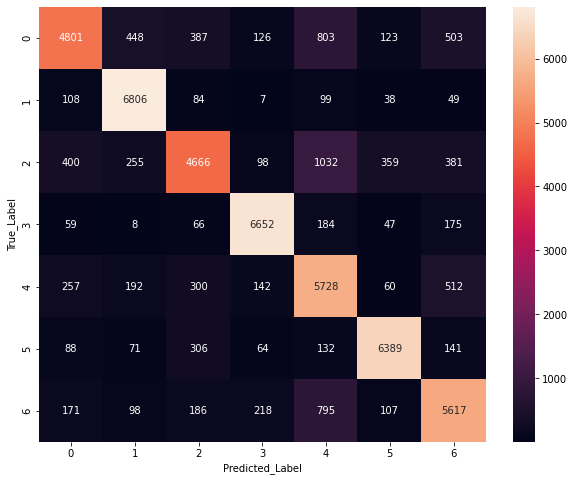

In [19]:
cf_matrix = confusion_matrix(y_train_reduced, model_classes)

plt.figure(figsize = (10,8))
sns.heatmap(cf_matrix, annot=True,fmt="d")
plt.xlabel('Predicted_Label')
plt.ylabel('True_Label')